In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [3]:
df = pd.read_csv("amz_uk_price_prediction_dataset.csv")
df.head(2)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers


### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*

In [4]:
crosstab = pd.crosstab(df['category'], df['isBestSeller'])
crosstab

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [5]:
crosstab['BestSeller_Proportion'] = crosstab[True] / (crosstab[True] + crosstab[False])*100

crosstab = crosstab.sort_values(by='BestSeller_Proportion', ascending=False)

crosstab


isBestSeller,False,True,BestSeller_Proportion
category,,,
Grocery,9008,556,5.813467
Smart Home Security & Lighting,98,6,5.769231
Health & Personal Care,9017,552,5.768628
Mobile Phone Accessories,248,11,4.247104
Power & Hand Tools,8353,306,3.533895
...,...,...,...
"CD, Disc & Tape Players",8798,0,0.000000
General Music-Making Accessories,259,0,0.000000
Snowboard Boots,1449,0,0.000000


2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

In [6]:
from scipy.stats import chi2_contingency

chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab)

chi2_statistic, chi2_p_value

(50603.56501614784, 0.0)

In [7]:
n = np.sum(crosstab.values)  # Número total de observaciones
min_dim = min(crosstab.shape) - 1  # Mínimo número de filas o columnas - 1
cramers_v = np.sqrt(chi2_statistic / (n * min_dim))

print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.10175125266461914


3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

C:\Users\Lidia Mayor\AppData\Local\Temp\ipykernel_25612\446439225.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  crosstab_ = crosstab_[crosstab['BestSeller_Proportion']>0.01]


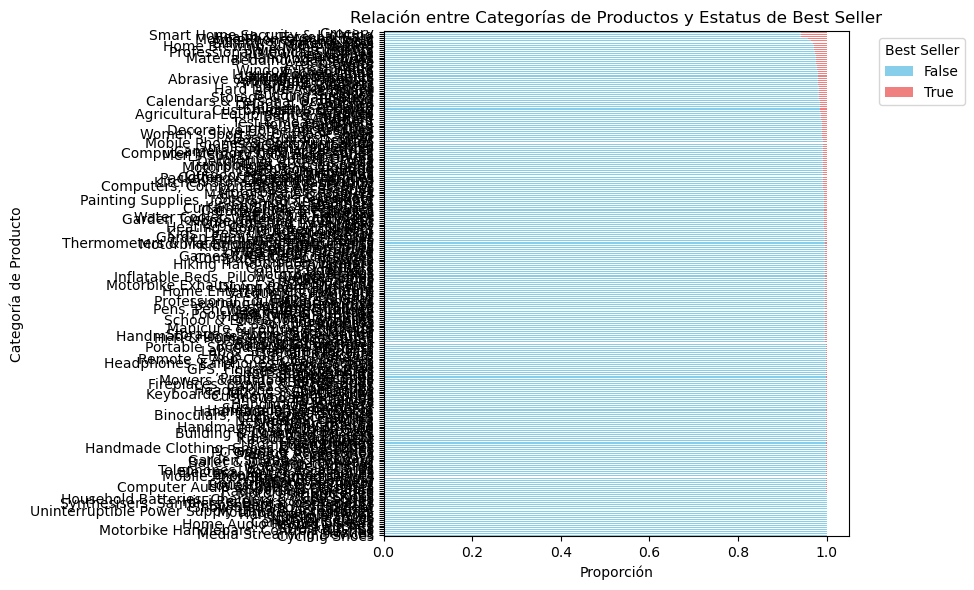

In [8]:
crosstab_ = pd.crosstab(df['category'], df['isBestSeller'])
crosstab_ = crosstab_[crosstab['BestSeller_Proportion']>0.01]
crosstab_norm = crosstab_.div(crosstab_.sum(axis=1), axis=0).sort_values(by=True, ascending=True)

crosstab_norm.plot(kind='barh', stacked=True, figsize=(10, 6), color=['skyblue', 'lightcoral'], legend = False)

plt.title('Relación entre Categorías de Productos y Estatus de Best Seller')
plt.ylabel('Categoría de Producto')
plt.xlabel('Proporción')
plt.legend(title='Best Seller', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

In [9]:
def tukeys_test_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify the outliers
    #outliers = data[(data < lower_bound) | (data > upper_bound)]
    df_no_outliers = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]
    
    return df_no_outliers

df_no_outliers = tukeys_test_outliers(df['price'])

In [10]:
df.shape

(2443651, 9)

In [11]:
df_no_outliers.shape

(2115963, 9)

1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.

In [12]:
top_20_categories = df_no_outliers['category'].value_counts().head(20).index
df_top_20 = df_no_outliers[df_no_outliers['category'].isin(top_20_categories)]


C:\Users\Lidia Mayor\AppData\Local\Temp\ipykernel_25612\2497161652.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_top_20, x='category', y='price', palette="coolwarm")


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'Handmade Home & Kitchen Products'),
  Text(1, 0, 'Sports & Outdoors'),
  Text(2, 0, 'Handmade Gifts'),
  Text(3, 0, 'Fragrances'),
  Text(4, 0, 'Skin Care'),
  Text(5, 0, 'Birthday Gifts'),
  Text(6, 0, 'Handmade Kitchen & Dining'),
  Text(7, 0, 'Bath & Body'),
  Text(8, 0, 'Manicure & Pedicure Products'),
  Text(9, 0, 'Beauty'),
  Text(10, 0, 'Handmade Artwork'),
  Text(11, 0, 'Make-up'),
  Text(12, 0, 'Baby'),
  Text(13, 0, 'Handmade Clothing, Shoes & Accessories'),
  Text(14, 0, 'Handmade Home Décor'),
  Text(15, 0, 'Men'),
  Text(16, 0, 'Luggage and travel gear'),
  Text(17, 0, 'Handmade Jewellery'),
  Text(18, 0, 'Women'),
  Text(19, 0, 'Hair Care')])

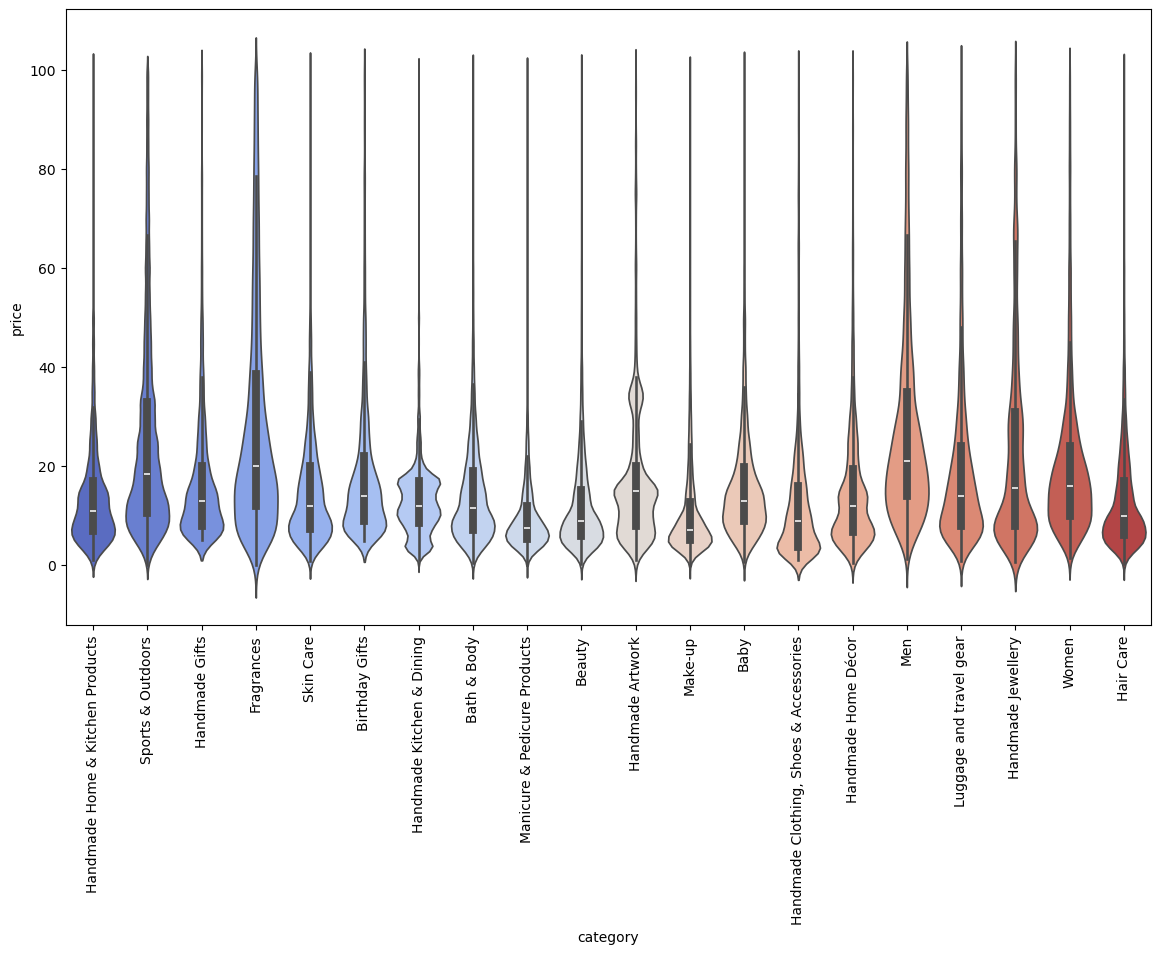

In [19]:
plt.figure(figsize=(14, 8))
sns.violinplot(data=df_top_20, x='category', y='price', palette="coolwarm")
plt.xticks(rotation=90)

In [22]:
# Calcular la mediana del precio por categoría
median_prices = df.groupby('category')['price'].median()

# Ordenar por la mediana del precio en orden descendente
highest_median_price_category = median_prices.sort_values(ascending=False)

# Mostrar la categoría con el precio mediano más alto
print(highest_median_price_category.head(1))

category
Laptops    1042.725
Name: price, dtype: float64


2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

In [28]:
mean_prices = df_no_outliers.groupby('category')['price'].mean().sort_values(ascending=False)
top_10_categories = df_no_outliers['category'].value_counts().nlargest(10).index
mean_prices = mean_prices.loc[top_10_categories]
mean_prices


category
Sports & Outdoors                         25.172065
Beauty                                    12.523480
Bath & Body                               14.678683
Manicure & Pedicure Products              10.231825
Handmade Clothing, Shoes & Accessories    12.958639
Make-up                                   10.612918
Skin Care                                 15.654722
Hair Care                                 13.461408
Birthday Gifts                            18.600195
Handmade Gifts                            17.395112
Name: price, dtype: float64

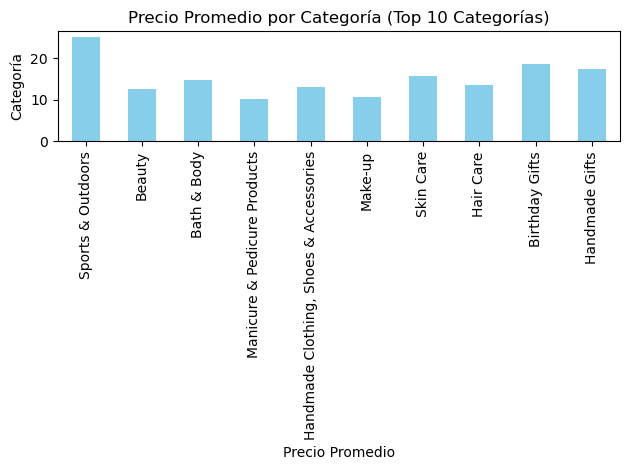

In [29]:
mean_prices.plot(kind='bar', color='skyblue')

# Añadir títulos y etiquetas
plt.title('Precio Promedio por Categoría (Top 10 Categorías)')
plt.xlabel('Precio Promedio')
plt.ylabel('Categoría')
plt.tight_layout()

In [31]:
mean_prices = df_no_outliers.groupby('category')['price'].mean().sort_values(ascending=False)
mean_prices.head(1)

category
Motherboards    68.772432
Name: price, dtype: float64

3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

C:\Users\Lidia Mayor\AppData\Local\Temp\ipykernel_25612\407939411.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='category', y='stars', data=df_top_10, palette='muted')


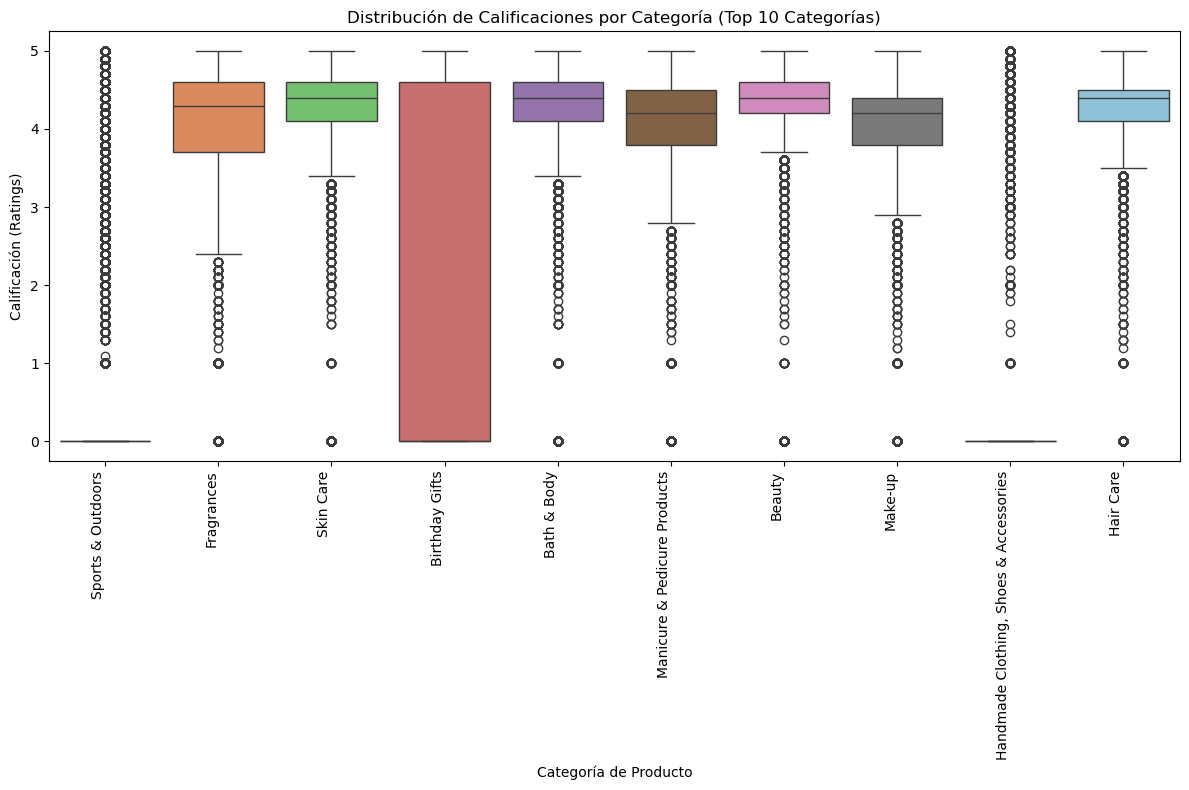

In [33]:
top_10_categories = df['category'].value_counts().head(10).index
df_top_10 = df[df['category'].isin(top_10_categories)]

# Crear un box plot para las 10 principales categorías mostrando las calificaciones (ratings)
plt.figure(figsize=(12, 8))
sns.boxplot(x='category', y='stars', data=df_top_10, palette='muted')

# Añadir títulos y etiquetas
plt.title('Distribución de Calificaciones por Categoría (Top 10 Categorías)')
plt.xlabel('Categoría de Producto')
plt.ylabel('Calificación (Ratings)')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [18]:
median_ratings = df.groupby('category')['stars'].median()

highest_median_rating_category = median_ratings.sort_values(ascending=False)

print(highest_median_rating_category.head(1))

category
Computer Memory    4.7
Name: stars, dtype: float64


### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.

1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?

In [19]:
correlation = df_no_outliers['price'].corr(df['stars'])
correlation

-0.07767299878181323

2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 

<Axes: xlabel='stars', ylabel='price'>

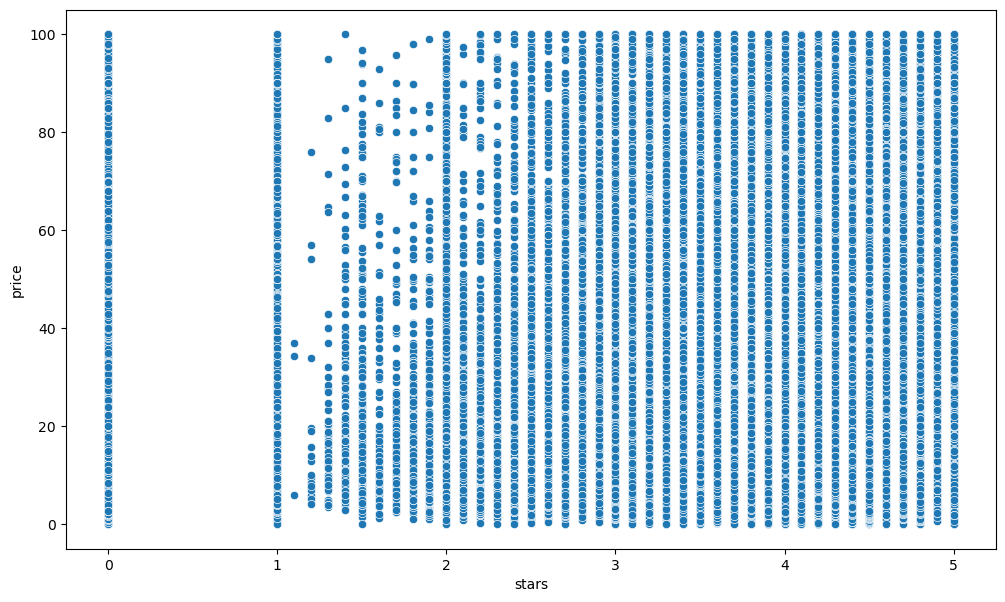

In [35]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=df_no_outliers, x='stars', y='price')

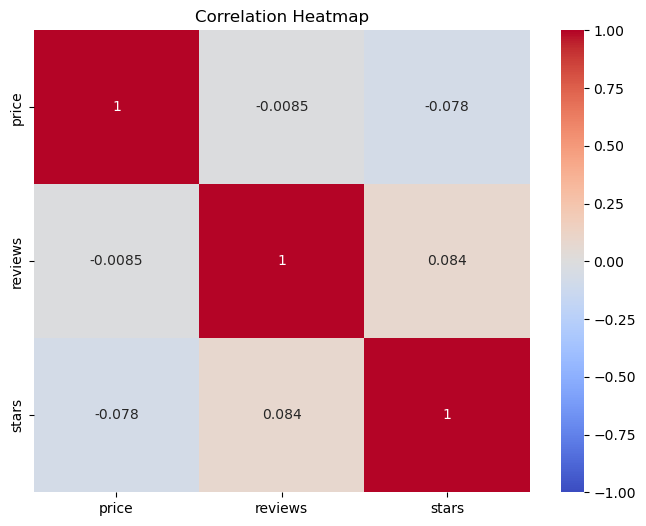

In [36]:
correlation_mtx = df_no_outliers[['price', 'reviews', 'stars']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation_mtx, annot=True, cmap='coolwarm',vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

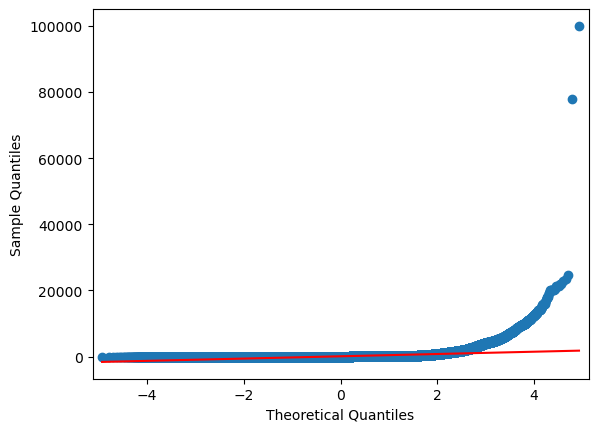

In [24]:
import statsmodels.api as sm
sm.qqplot(df['price'], line='s');

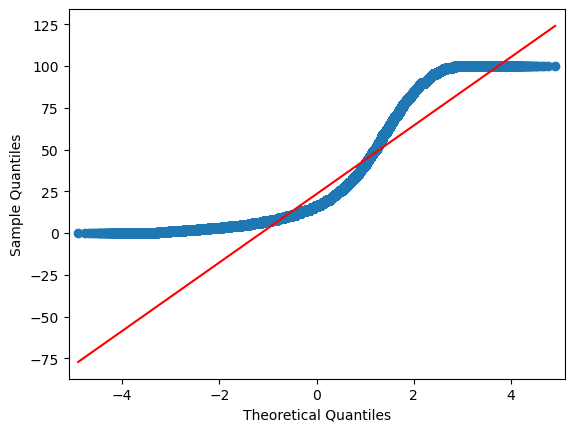

In [25]:
import statsmodels.api as sm
sm.qqplot(df_no_outliers['price'], line='s');